## CONVOLUTIONAL NEURAL NETWORK

- Assignment:
Train image classification model for digit recognition with simple artificial neural network.

In [1]:
import numpy as np
import torch
from torch import nn, optim
from torchvision import datasets, transforms # utilities for sample dataset and image transformation
from torch.utils.data import DataLoader # for efficient data loading during training and inference

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm # for progress bar

In [2]:
# setup the transformation channel

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

# load the dataset
train_data = datasets.MNIST(root='./data', train = True, transform=transform,
                            download=True)
test_data = datasets.MNIST(root='./data', train = False, transform=transform,
                            download=True)

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 28.9k/28.9k [00:00<00:00, 460kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.10MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.34MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# setup the data loader

train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle = True)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle = True)

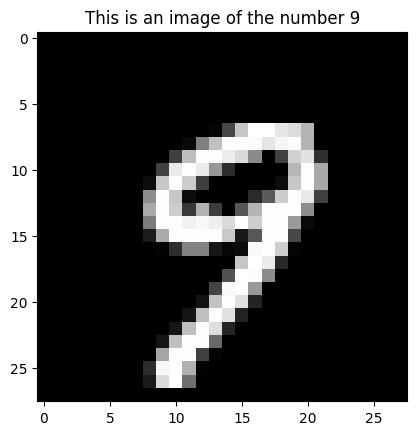

In [10]:
def show_image(image_index):
  image, label = train_data[image_index][0], train_data[image_index][1]
  image = image.detach().numpy()
  image = np.transpose(image, (1,2,0))
  plt.imshow(image, cmap = 'grey')
  plt.title(f'This is an image of the number {label}')


show_image(image_index=167)

In [5]:
# set up the device configuration
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
# set up the model architecture

class Image_CNN(nn.Module):

  def __init__(self) -> None:
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size= 3, stride = 1, padding = 1) # 32 by 28 by 28
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride = 1, padding = 1) # 64 by 28 by 28
    self.pool = nn.MaxPool2d(kernel_size=2, stride = 2) # 64 by 14 by 14 -> after one round of poling, # 64 by 7 by 7 -> two rounds
    self.fc1 = nn.Linear(in_features=64*7*7, out_features=500)
    self.fc2 = nn.Linear(in_features=500, out_features=250)
    self.out = nn.Linear(in_features=250, out_features=10)
    self.dropout = nn.Dropout(0.5)
    self.relu = nn.ReLU()

  def forward(self, x:torch.Tensor):
    result = self.pool(self.conv1(x))
    result = self.pool(self.conv2(result))
    result = result.view(-1, 64*7*7)
    result = self.dropout(self.relu(self.fc1(result)))
    result = self.dropout(self.relu(self.fc2(result)))
    result = self.out(result)

    return result

In [12]:
# init the model and hyper parameters

model = Image_CNN().to(device) # init the model and we transfered it to our gpu
learning_rate = 1e-4
EPOCHS = 5
optimizer = optim.Adam(params = model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [24]:
# begin the training loop

model.train() # put model in training mode
all_preds = []
all_labels = []

for epoch in range(5):
  current_batch = tqdm(train_loader, desc = f'epoch: {epoch+1}/{EPOCHS}')
  batch_pred = []
  batch_labels = []
  for images, labels in current_batch:
    images, labels = images.to(device), labels.to(device)
    # forward pass
    train_preds = model(images)
    loss = criterion(train_preds, labels)

    # back propagation

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    _, preds = torch.max(train_preds, 1)
    preds = preds.cpu().numpy()
    batch_pred.extend(preds)
    batch_labels.extend(labels.cpu().numpy())

  all_labels.extend(batch_labels)
  all_preds.extend(batch_pred)

  print(f'Epoch: {epoch}........Loss: {loss.item()}')

epoch: 1/5: 100%|██████████| 938/938 [00:17<00:00, 54.64it/s]


Epoch: 0........Loss: 0.004161059856414795


epoch: 2/5: 100%|██████████| 938/938 [00:18<00:00, 50.85it/s]


Epoch: 1........Loss: 0.010533243417739868


epoch: 3/5: 100%|██████████| 938/938 [00:32<00:00, 29.19it/s]


Epoch: 2........Loss: 0.10186688601970673


epoch: 4/5: 100%|██████████| 938/938 [00:28<00:00, 33.36it/s]


Epoch: 3........Loss: 0.0003910346422344446


epoch: 5/5: 100%|██████████| 938/938 [00:15<00:00, 61.39it/s]

Epoch: 4........Loss: 0.0009025111794471741


In [25]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29615
           1       1.00      1.00      1.00     33710
           2       0.99      0.99      0.99     29790
           3       0.99      0.99      0.99     30655
           4       0.99      0.99      0.99     29210
           5       0.99      0.99      0.99     27105
           6       0.99      0.99      0.99     29590
           7       0.99      0.99      0.99     31325
           8       0.99      0.99      0.99     29255
           9       0.99      0.99      0.99     29745

    accuracy                           0.99    300000
   macro avg       0.99      0.99      0.99    300000
weighted avg       0.99      0.99      0.99    300000



<Axes: >

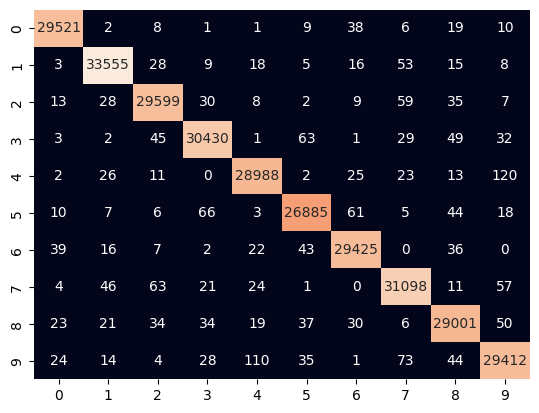

In [26]:
sns.heatmap(data = confusion_matrix(all_labels, all_preds),
            annot = True,fmt = 'd', cbar = False)

In [30]:
# inference
model.eval()
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    test_preds = model(images)
    _, test_preds = torch.max(test_preds, 1)
    test_preds = test_preds.cpu().numpy()

test_preds

array([0, 5, 0, 4, 8, 0, 9, 6, 9, 8, 2, 8, 1, 8, 3, 4])

In [31]:
labels = labels.cpu().numpy()
print(classification_report(labels, test_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         2

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

